In [1]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

In [2]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
#years = ['2025']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

lat_range_input=[0,5]      
lon_range_input=[123, 133.0] 

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 


df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

In [16]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=True  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )



그리드 분석

In [8]:
import torch
import numpy as np

def analyze_tensor_stability_by_time(tensor_list):
    """
    Input: daily_aggregated_tensors_dw (List[Tensor])
    Logic:
      1. 리스트의 첫 번째 텐서(Day 0)를 꺼냅니다.
      2. 4번째 컬럼(Time)을 기준으로 유니크한 시간대(8개)를 찾습니다.
      3. 각 시간대별로 (Lat, Lon) 좌표를 추출하여, 첫 번째 시간대와 비교합니다.
    """
    print(f"--- Analyzing Coordinate Stability within Aggregated Tensor ---")
    
    # 1. 첫 번째 날짜 텐서 가져오기
    if len(tensor_list) == 0:
        print("Error: Input list is empty.")
        return
    
    # [N_total, 4] 형태의 텐서 (Lat, Lon, Val, Time)
    day_tensor = tensor_list[0] 
    
    print(f"Tensor Shape: {day_tensor.shape}")
    
    # 2. Time 컬럼(인덱스 3) 추출 및 유니크 값 확인
    times = day_tensor[:, 3]
    unique_times = torch.unique(times, sorted=True)
    
    print(f"Detected {len(unique_times)} unique time steps: {unique_times.tolist()}")
    
    if len(unique_times) < 2:
        print("Not enough time steps to compare.")
        return

    # 3. 기준 좌표 (첫 번째 시간대) 설정
    base_time = unique_times[0]
    base_mask = (times == base_time)
    
    # [N_points, 2] (Lat, Lon)
    base_coords = day_tensor[base_mask, :2].detach().cpu().numpy()
    
    print(f"Base Time ({base_time.item()}): {base_coords.shape[0]} points")
    
    # 4. 나머지 시간대와 비교 Loop
    is_stable = True
    max_drift_list = []
    
    for t_idx in range(1, len(unique_times)):
        curr_time = unique_times[t_idx]
        curr_mask = (times == curr_time)
        curr_coords = day_tensor[curr_mask, :2].detach().cpu().numpy()
        
        # (A) 데이터 개수 비교 (Cloud Masking 여부 확인)
        if base_coords.shape[0] != curr_coords.shape[0]:
            print(f"⚠️ [MISMATCH] Time {curr_time.item()}: Count {curr_coords.shape[0]} != Base {base_coords.shape[0]}")
            is_stable = False
            continue
            
        # (B) 좌표 값 차이 계산
        # 순서가 섞여있을 수도 있으므로 정렬하지 않고, 
        # "데이터 로더가 순서를 보장한다"는 가정하에 1:1 비교를 수행합니다.
        # (만약 로더가 셔플했다면 이 비교는 실패하지만, 보통 시계열 데이터는 순차적입니다.)
        diff = np.abs(base_coords - curr_coords)
        max_diff = np.max(diff)
        mean_diff = np.mean(diff)
        
        max_drift_list.append(max_diff)
        
        print(f"Time {curr_time.item()} vs Base: Max Diff = {max_diff:.9f} deg")
        
        if max_diff > 1e-6:
            is_stable = False
            
    # 5. 최종 결론
    print("-" * 50)
    if is_stable:
        print("✅ [CONCLUSION] Hourly Coordinates are FIXED (Identical).")
        print("   -> 시간별 인덱스 캐싱 필요 없음 (1개만 쓰면 됨).")
    else:
        avg_drift = np.mean(max_drift_list) if max_drift_list else 0
        print("⚠️ [CONCLUSION] Hourly Coordinates are DYNAMIC (Jitter Detected).")
        print(f"   -> Average Max Drift: {avg_drift:.6f} degrees")
        print("   -> [Action] 반드시 '시간대별 인덱스 캐싱(Dictionary)' 방식을 써야 합니다.")

# 실행
analyze_tensor_stability_by_time(daily_aggregated_tensors_dw)

--- Analyzing Coordinate Stability within Aggregated Tensor ---
Tensor Shape: torch.Size([145008, 4])
Detected 8 unique time steps: [21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0]
Base Time (21.0): 18126 points
Time 22.0 vs Base: Max Diff = 0.689126540 deg
Time 23.0 vs Base: Max Diff = 0.611120000 deg
Time 24.0 vs Base: Max Diff = 0.484150000 deg
Time 25.0 vs Base: Max Diff = 0.453895000 deg
Time 26.0 vs Base: Max Diff = 0.351870000 deg
Time 27.0 vs Base: Max Diff = 0.049794660 deg
Time 28.0 vs Base: Max Diff = 0.038740000 deg
--------------------------------------------------
⚠️ [CONCLUSION] Hourly Coordinates are DYNAMIC (Jitter Detected).
   -> Average Max Drift: 0.382671 degrees
   -> [Action] 반드시 '시간대별 인덱스 캐싱(Dictionary)' 방식을 써야 합니다.


--- Checking Grid Stability over 28 days ---

[Analysis Result using first 28 days]
Mean Latitude Drift (Std): 0.019968 degrees
Mean Longitude Drift (Std): 0.027936 degrees


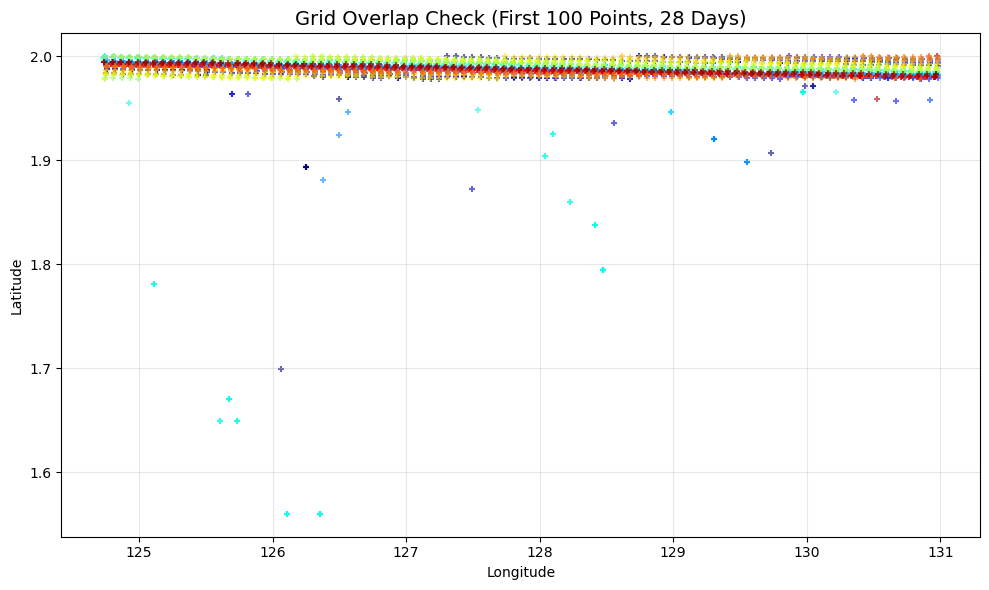


⚠️ 결론: 이 데이터는 '유동 격자(Dynamic Grid)'입니다.
   매일 좌표가 조금씩 바뀝니다. Nearest Neighbor 매핑을 매일 새로 해야 합니다.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def check_grid_stability(data_maps, days_to_check=10):
    """
    여러 날짜의 데이터에서 '좌표(Lat, Lon)'만 뽑아서
    시간이 지나도 좌표가 고정되어 있는지(Fixed Grid) 흔들리는지(Jitter) 분석합니다.
    """
    print(f"--- Checking Grid Stability over {days_to_check} days ---")
    
    # [시간대 고정] 가장 데이터가 많은 '오후 2시(Hour 5)' 등을 기준으로 비교
    target_hour_idx = 4 
    
    collected_lats = []
    collected_lons = []
    
    valid_days = 0
    
    for day_idx in range(days_to_check):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        if len(sorted_keys) <= target_hour_idx:
            continue
            
        # 특정 시간대의 텐서 가져오기
        key = sorted_keys[target_hour_idx]
        tensor = day_data[key]
        
        if isinstance(tensor, torch.Tensor):
            data = tensor.detach().cpu().numpy()
        else:
            data = tensor
            
        # 데이터가 비어있으면 스킵
        if data.size == 0: continue
        
        # 데이터 개수가 날짜마다 다르면 1:1 비교가 불가능하므로 개수 체크
        # (위성 데이터는 구름 등으로 인해 결측이 생겨 개수가 다를 수 있음 -> 앞부분 1000개만 잘라서 비교)
        min_len = min(len(data), 1000) 
        
        collected_lats.append(data[:min_len, 0]) # Lat
        collected_lons.append(data[:min_len, 1]) # Lon
        valid_days += 1

    if valid_days < 2:
        print("Not enough days to compare.")
        return

    # Numpy 변환 (Days, Points)
    lats_stack = np.stack(collected_lats, axis=0)
    lons_stack = np.stack(collected_lons, axis=0)
    
    # 1. 표준편차(Std) 계산: 날짜별로 좌표가 얼마나 흔들리는지
    lat_std = np.std(lats_stack, axis=0)
    lon_std = np.std(lons_stack, axis=0)
    
    mean_lat_drift = np.mean(lat_std)
    mean_lon_drift = np.mean(lon_std)
    
    print(f"\n[Analysis Result using first {valid_days} days]")
    print(f"Mean Latitude Drift (Std): {mean_lat_drift:.6f} degrees")
    print(f"Mean Longitude Drift (Std): {mean_lon_drift:.6f} degrees")
    
    # 2. 시각화 (Zoom-in)
    # 첫 100개 포인트에 대해 여러 날짜의 좌표를 겹쳐 그리기
    plt.figure(figsize=(10, 6))
    
    colors = plt.cm.jet(np.linspace(0, 1, valid_days))
    
    for i in range(valid_days):
        plt.scatter(lons_stack[i, :100], lats_stack[i, :100], 
                    s=20, alpha=0.6, label=f'Day {i}', color=colors[i], marker='+')
        
    plt.title(f"Grid Overlap Check (First 100 Points, {valid_days} Days)", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, alpha=0.3)
    # plt.legend() # 범례가 너무 많으면 뺌
    plt.tight_layout()
    plt.show()
    
    # 해석 출력
    threshold = 1e-4 # 0.0001도 (약 10m 오차)
    if mean_lat_drift < threshold and mean_lon_drift < threshold:
        print("\n✅ 결론: 이 데이터는 '고정 격자(Fixed Grid)'입니다.")
        print("   매일 좌표가 거의 똑같습니다. 위성 관측 지점이 고정되어 있습니다.")
    else:
        print("\n⚠️ 결론: 이 데이터는 '유동 격자(Dynamic Grid)'입니다.")
        print("   매일 좌표가 조금씩 바뀝니다. Nearest Neighbor 매핑을 매일 새로 해야 합니다.")

# 실행
check_grid_stability(daily_hourly_maps_dw, days_to_check=28)



🔍 Quantitative Spatial Analysis (Day 0, Time 0)
📌 Total Data Points: 18126

📊 [Overlap Statistics]
   - Minimum Distance: 0.0000000000 degrees
   - Pairs with dist ≈ 0.0 (Exact Duplicates): 	54 pairs ❌ (FATAL)
   - Pairs with dist < 1e-6 (~10cm):           	54 pairs 💥 (CRITICAL)
   - Pairs with dist < 1e-4 (~10m):            	54 pairs ⚠️ (WARNING)

>> 🛑 결론: 중복되거나 극도로 가까운 좌표가 존재합니다. Cholesky 분해가 실패할 확률이 매우 높습니다.


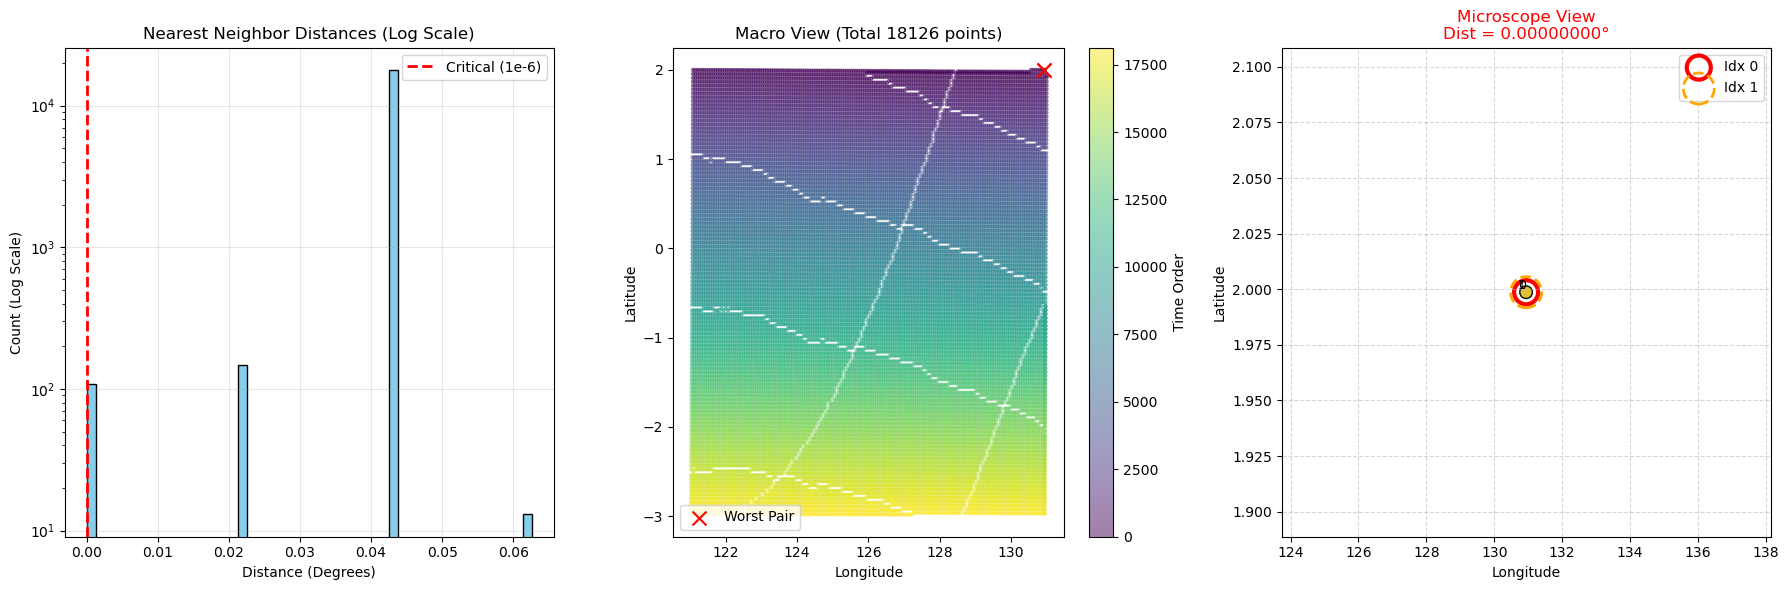

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.spatial.distance import cdist

def quantify_and_visualize_overlap(data_maps, day_idx=0, time_idx=0):
    """
    1. 모든 점들 간의 거리를 계산하여 히스토그램으로 분포를 보여줍니다.
    2. '위험 거리(Threshold)' 안에 들어오는 쌍(Pair)이 몇 개인지 정확히 숫자로 셉니다.
    3. 가장 가까운 쌍을 찾아 현미경처럼 확대해서 보여줍니다.
    """
    print(f"\n{'='*60}")
    print(f"🔍 Quantitative Spatial Analysis (Day {day_idx}, Time {time_idx})")
    print(f"{'='*60}")
    
    # --- 1. 데이터 추출 ---
    if day_idx >= len(data_maps) or data_maps[day_idx] is None:
        print("Error: Data is None or Index out of range.")
        return

    try:
        sorted_keys = sorted(data_maps[day_idx].keys(), key=lambda x: int(x) if str(x).isdigit() else x)
    except:
        sorted_keys = sorted(data_maps[day_idx].keys())
        
    if time_idx >= len(sorted_keys):
        print("Error: Time index out of range.")
        return

    key = sorted_keys[time_idx]
    tensor = data_maps[day_idx][key]
    
    if isinstance(tensor, torch.Tensor):
        data = tensor.detach().cpu().numpy()
    else:
        data = tensor
        
    coords = data[:, :2] # Lat, Lon
    N = len(coords)
    print(f"📌 Total Data Points: {N}")
    
    # --- 2. 거리 행렬 계산 (Distance Matrix) ---
    # cdist: 모든 점 vs 모든 점 거리 계산 (N x N 행렬)
    dists = cdist(coords, coords)
    
    # 자기 자신과의 거리(0) 및 중복 계산(A-B, B-A) 방지
    # 상삼각행렬(Upper Triangle)만 추출 (k=1: 대각선 제외)
    # 이렇게 하면 (i, j) 쌍을 한 번만 카운트함
    upper_tri_indices = np.triu_indices(N, k=1)
    pair_dists = dists[upper_tri_indices]
    
    # --- 3. 정량 분석 (Quantification) ---
    # 위험 구간 설정 (Degrees)
    thresh_exact = 1e-12      # 사실상 완전 중복 (float 정밀도 한계)
    thresh_danger = 1e-6      # 약 10cm (Singular 유발 가능성 매우 높음)
    thresh_warning = 1e-4     # 약 10m (물리적으로 너무 가까움)
    
    count_exact = np.sum(pair_dists < thresh_exact)
    count_danger = np.sum(pair_dists < thresh_danger)
    count_warning = np.sum(pair_dists < thresh_warning)
    
    min_dist_idx = np.argmin(pair_dists)
    min_val = pair_dists[min_dist_idx]
    
    print(f"\n📊 [Overlap Statistics]")
    print(f"   - Minimum Distance: {min_val:.10f} degrees")
    print(f"   - Pairs with dist ≈ 0.0 (Exact Duplicates): \t{count_exact} pairs ❌ (FATAL)")
    print(f"   - Pairs with dist < 1e-6 (~10cm):           \t{count_danger} pairs 💥 (CRITICAL)")
    print(f"   - Pairs with dist < 1e-4 (~10m):            \t{count_warning} pairs ⚠️ (WARNING)")
    
    if count_exact > 0 or count_danger > 0:
        print("\n>> 🛑 결론: 중복되거나 극도로 가까운 좌표가 존재합니다. Cholesky 분해가 실패할 확률이 매우 높습니다.")
    else:
        print("\n>> ✅ 결론: 좌표 간격이 충분히 확보되었습니다.")

    # --- 4. 시각화 (Plotting) ---
    fig = plt.figure(figsize=(18, 6))
    
    # [Subplot 1] Nearest Neighbor Distance Histogram
    # 각 점에서 "가장 가까운 이웃까지의 거리" 분포
    # (pair_dists 전체를 찍으면 너무 많으므로, 각 점별 최소 거리만 봄)
    np.fill_diagonal(dists, np.inf)
    nearest_neighbor_dists = np.min(dists, axis=1)
    
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.hist(nearest_neighbor_dists, bins=50, color='skyblue', edgecolor='black', log=True)
    ax1.axvline(thresh_danger, color='red', linestyle='dashed', linewidth=2, label='Critical (1e-6)')
    ax1.set_title("Nearest Neighbor Distances (Log Scale)", fontsize=12)
    ax1.set_xlabel("Distance (Degrees)")
    ax1.set_ylabel("Count (Log Scale)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # [Subplot 2] Macro View (전체 경로)
    # 가장 가까운 두 점 찾기 (원래 로직)
    full_min_idx = np.unravel_index(np.argmin(dists), dists.shape)
    idx1, idx2 = full_min_idx
    p1, p2 = coords[idx1], coords[idx2]
    
    lats, lons = coords[:, 0], coords[:, 1]
    
    ax2 = fig.add_subplot(1, 3, 2)
    sc2 = ax2.scatter(lons, lats, c=np.arange(N), cmap='viridis', s=5, alpha=0.5)
    ax2.scatter([p1[1], p2[1]], [p1[0], p2[0]], color='red', s=100, marker='x', label='Worst Pair')
    ax2.set_title(f"Macro View (Total {N} points)", fontsize=12)
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    ax2.legend()
    plt.colorbar(sc2, ax=ax2, label='Time Order')
    
    # [Subplot 3] Microscope View (확대)
    ax3 = fig.add_subplot(1, 3, 3)
    
    zoom_radius = max(min_val * 10, 0.0005) # 최소 0.0005도는 보여줌
    
    mask = (lons > p1[1] - zoom_radius) & (lons < p1[1] + zoom_radius) & \
           (lats > p1[0] - zoom_radius) & (lats < p1[0] + zoom_radius)
    
    subset_lons = lons[mask]
    subset_lats = lats[mask]
    subset_indices = np.arange(N)[mask]
    
    ax3.scatter(subset_lons, subset_lats, c=subset_indices, cmap='viridis', s=80, alpha=0.8, edgecolor='k')
    
    # Worst Pair Highlight
    ax3.scatter(p1[1], p1[0], s=300, facecolors='none', edgecolors='red', linewidth=3, label=f'Idx {idx1}')
    ax3.scatter(p2[1], p2[0], s=500, facecolors='none', edgecolors='orange', linewidth=2, linestyle='--', label=f'Idx {idx2}')
    
    for x, y, idx in zip(subset_lons, subset_lats, subset_indices):
        ax3.text(x, y, str(idx), fontsize=9, ha='right', va='bottom')
        
    ax3.set_title(f"Microscope View\nDist = {min_val:.8f}°", fontsize=12, color='red')
    ax3.set_xlabel("Longitude")
    ax3.set_ylabel("Latitude")
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# --- 실행 ---
# 'daily_hourly_maps_dw'를 넣어서 확인해보세요.
# Jitter를 안 넣었거나 Binning을 안 했다면, Count가 0이 아닐 것입니다.
quantify_and_visualize_overlap(daily_hourly_maps_dw)

2024

# 2,7 blank on lat:3,5  
# 1,1 blank on lon:130,132
# 10,5 blank on lon:128,130 serious
# 23,3 blank on everywhere
# 1,[4,5,6,7] 132 오른쪽 무

i should choose longitude 120.5 to 130.5 


2025 

# 1,1 big holes 
# 6,6

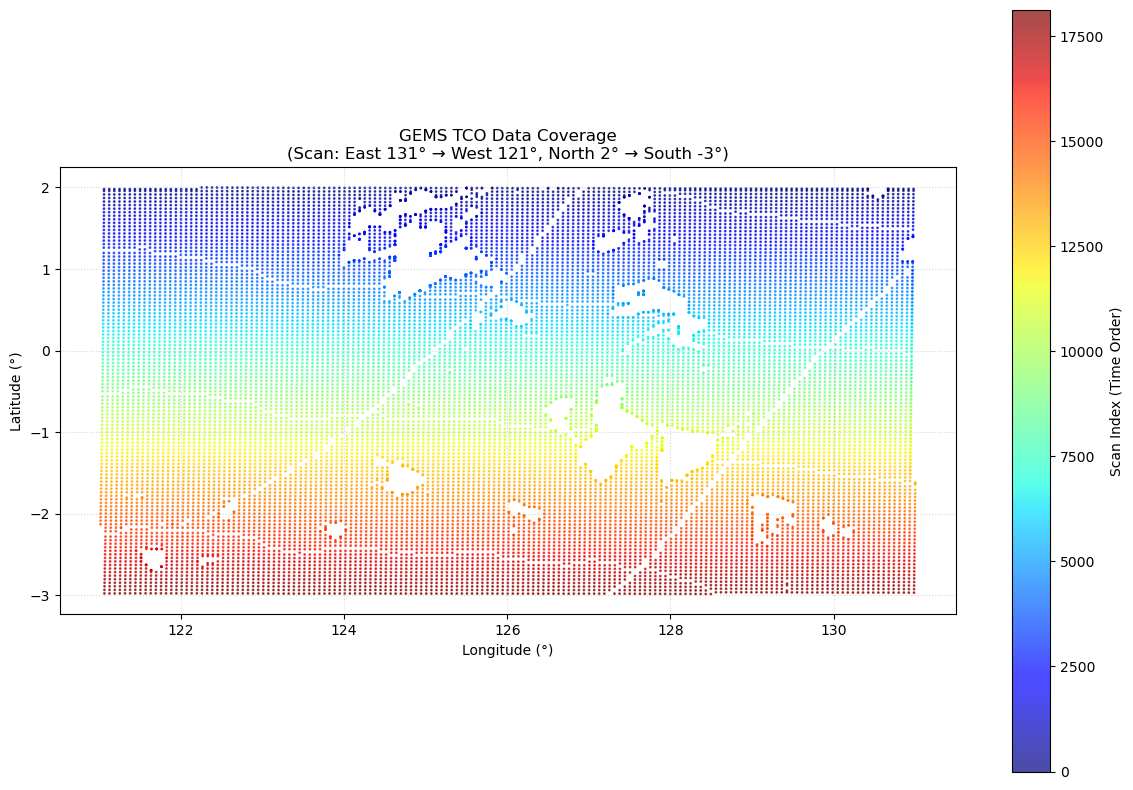

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

day = 8
hour = 4
keys = list(daily_hourly_maps_dw[day].keys())
# 1. Get the specific tensor data
data_tensor = daily_hourly_maps_dw[day][keys[hour]]

# Convert to numpy for plotting (assuming CPU tensor)
# If on GPU, use .cpu().numpy()
data = data_tensor.numpy()

# 2. Extract Coordinates
# Based on your previous tensor snippet: Column 0 is Lat, Column 1 is Lon
lats = data[:, 0]
lons = data[:, 1]

# 3. Setup the Main Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: Color by index to show the scan path (East -> West, North -> South)
# s=1 makes the points small enough to see the density without overlapping too much
sc = ax.scatter(lons, lats, c=np.arange(len(lats)), cmap='jet', s=1, alpha=0.7)
cbar = plt.colorbar(sc, label='Scan Index (Time Order)')

ax.set_title(f'GEMS TCO Data Coverage\n(Scan: East {lon_range_input[1]}° → West {lon_range_input[0]}°, North {lat_range_input[1]}° → South {lat_range_input[0]}°)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(True, linestyle=':', alpha=0.5)

# Ensure aspect ratio is equal so 1 degree Lat looks the same as 1 degree Lon
ax.set_aspect('equal')

# 4. Create Zoomed Inset to Exemplify Scale/Grid Structure


# Location: Lower Left of the plot
#axins = inset_axes(ax, width="30%", height="30%", loc='lower left', borderpad=3)

# Filter data for the center of the region to zoom in
center_lat = 4.
center_lon = 130.5
zoom_radius = 0.2  # +/- 0.2 degrees (total window ~0.4 degrees)

mask = (lats > center_lat - zoom_radius) & (lats < center_lat + zoom_radius) & \
       (lons > center_lon - zoom_radius) & (lons < center_lon + zoom_radius)

subset_lats = lats[mask]
subset_lons = lons[mask]

# Plot the subset in the inset with larger markers
axins.scatter(subset_lons, subset_lats, c='k', s=10)

# Set limits for the inset
axins.set_xlim(center_lon - zoom_radius, center_lon + zoom_radius)
axins.set_ylim(center_lat - zoom_radius, center_lat + zoom_radius)
axins.set_title("Zoom: Local Grid Structure")
axins.grid(True)

# 5. Add a Physical Scale Bar to the Inset
# At Equator/Low Latitudes, 1° Lat ≈ 110.57 km, 1° Lon ≈ 111.32 km * cos(lat)
# For Lat ~2.5°, cos(2.5°) is approx 1, so ~111km per degree is a safe estimate.
km_per_deg = 111.0
scale_bar_deg = 0.1  # We want to show a bar representing 0.1 degrees
scale_bar_km = scale_bar_deg * km_per_deg

# Draw the scale line in the inset (bottom right corner of inset)
bar_x = center_lon + zoom_radius * 0.4
bar_y = center_lat - zoom_radius * 0.8

axins.plot([bar_x, bar_x + scale_bar_deg], [bar_y, bar_y], 'r-', linewidth=3)
axins.text(bar_x + scale_bar_deg/2, bar_y + 0.02, f'{scale_bar_km:.1f} km', 
           color='red', ha='center', fontweight='bold', fontsize=10)

# Connect inset to main plot
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

First two latitude rows.

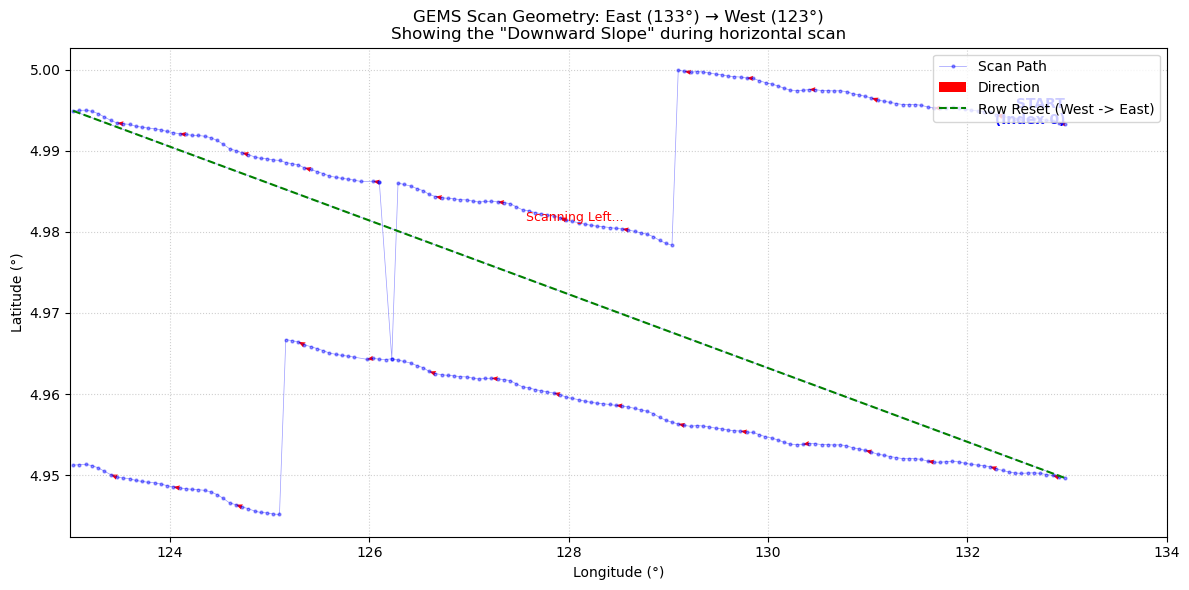

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---
day = 1
keys = list(daily_hourly_maps_dw[day].keys())
data_tensor = daily_hourly_maps_dw[day][keys[1]]
data = data_tensor.numpy() 

lats = data[:, 0]
lons = data[:, 1]

# --- 2. Isolate First 2 Rows to "Amplify" the view ---
# Find where the longitude jumps back to the East (Start of new row)
# The diff will be positive and large (~10 degrees) when resetting 123 -> 133
lon_diff = np.diff(lons)
row_starts = np.where(lon_diff > 5.0)[0] + 1 
row_starts = np.insert(row_starts, 0, 0)

# Slice only the first 2 full rows (approx 200-400 points) to keep it clean
if len(row_starts) > 2:
    slice_end = row_starts[2]
else:
    slice_end = len(lats)

sub_lats = lats[:slice_end]
sub_lons = lons[:slice_end]

# --- 3. Plotting ---
fig, ax = plt.subplots(figsize=(12, 6))

# A. Plot the connected path (The Trace)
ax.plot(sub_lons, sub_lats, 'b.-', markersize=4, linewidth=0.5, alpha=0.4, label='Scan Path')

# B. Add Arrows to show direction (East -> West)
# We plot an arrow every 10 points to avoid clutter
step = 10
# u, v are the components of the arrow vectors
u = np.diff(sub_lons, append=sub_lons[-1])[::step]
v = np.diff(sub_lats, append=sub_lats[-1])[::step]
q_lons = sub_lons[::step]
q_lats = sub_lats[::step]

ax.quiver(q_lons, q_lats, u, v, angles='xy', scale_units='xy', scale=1, 
          color='red', width=0.004, headwidth=4, label='Direction')

# C. Highlight the "Row Jump" (The Reset)
# This connects the end of Row 1 (West) to the start of Row 2 (East)
# We make this a dashed green line to show it's a "reset" motion, not a scan
if len(row_starts) > 1:
    jump_idx = row_starts[1] - 1
    ax.plot(sub_lons[jump_idx:jump_idx+2], sub_lats[jump_idx:jump_idx+2], 
            'g--', linewidth=1.5, label='Row Reset (West -> East)')

# D. Annotate Start and End of the first row to be clear
ax.text(sub_lons[0], sub_lats[0], ' START\n (Index 0)', color='blue', fontweight='bold', ha='right')
mid_idx = row_starts[1] // 2
ax.text(sub_lons[mid_idx], sub_lats[mid_idx], ' Scanning Left...', color='red', fontsize=9, ha='center')

# --- 4. Crucial Formatting for the "Slope" ---
ax.set_title('GEMS Scan Geometry: East (133°) → West (123°)\nShowing the "Downward Slope" during horizontal scan')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# FORCE Standard Map Orientation: 123 Left, 133 Right
ax.set_xlim(123, 134) 

# DO NOT use "equal" aspect. 
# We explicitly stretch the Y-axis so a 0.05 degree drop looks huge.
# If your lats are around 4.0 to 5.0, this will auto-scale to show the slant.

ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Row 10 and 11

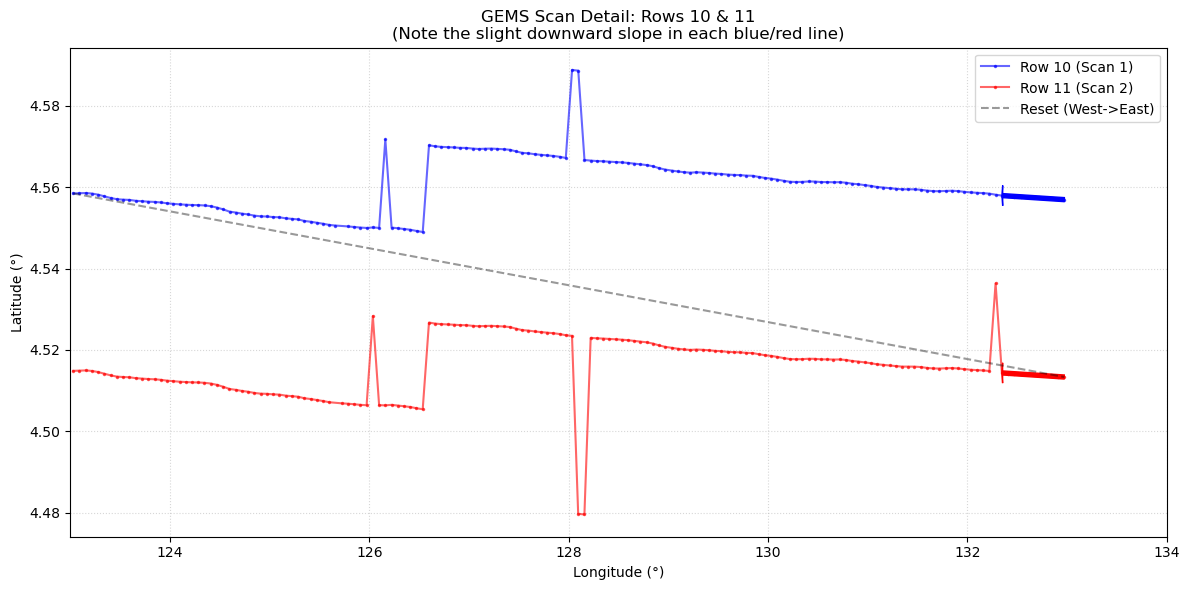

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load Data ---
day = 1
keys = list(daily_hourly_maps_dw[day].keys())
data_tensor = daily_hourly_maps_dw[day][keys[1]]
data = data_tensor.numpy() 

lats = data[:, 0]
lons = data[:, 1]

# --- 2. Identify Rows ---
# Find indices where Longitude jumps positive (resetting from West back to East)
lon_diff = np.diff(lons)
row_starts = np.where(lon_diff > 5.0)[0] + 1 
row_starts = np.insert(row_starts, 0, 0) # Include the very first start

# --- 3. Select Two "Middle" Consecutive Rows ---
# Let's pick Row 10 and Row 11 (arbitrary middle rows) to avoid edge cases
# If the data is small, we fallback to Row 0 and 1
start_row_idx = 10 if len(row_starts) > 12 else 0

idx_start_1 = row_starts[start_row_idx]
idx_end_1   = row_starts[start_row_idx + 1]
idx_end_2   = row_starts[start_row_idx + 2]

# Extract Data for Row A and Row B
row_a_lons = lons[idx_start_1:idx_end_1]
row_a_lats = lats[idx_start_1:idx_end_1]

row_b_lons = lons[idx_end_1:idx_end_2]
row_b_lats = lats[idx_end_1:idx_end_2]

# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Row A (The Upper Row)
ax.plot(row_a_lons, row_a_lats, 'b.-', label=f'Row {start_row_idx} (Scan 1)', markersize=3, alpha=0.6)
# Add arrow for Row A
ax.arrow(row_a_lons[0], row_a_lats[0], row_a_lons[10]-row_a_lons[0], row_a_lats[10]-row_a_lats[0], 
         head_width=0.005, color='blue', length_includes_head=True)

# Plot Row B (The Lower Row)
ax.plot(row_b_lons, row_b_lats, 'r.-', label=f'Row {start_row_idx+1} (Scan 2)', markersize=3, alpha=0.6)
# Add arrow for Row B
ax.arrow(row_b_lons[0], row_b_lats[0], row_b_lons[10]-row_b_lons[0], row_b_lats[10]-row_b_lats[0], 
         head_width=0.005, color='red', length_includes_head=True)

# Visualize the "Jump" (Reset)
# Connect End of Row A -> Start of Row B
ax.plot([row_a_lons[-1], row_b_lons[0]], [row_a_lats[-1], row_b_lats[0]], 
        'k--', alpha=0.4, label='Reset (West->East)')

# --- 5. Formatting ---
ax.set_title(f'GEMS Scan Detail: Rows {start_row_idx} & {start_row_idx+1}\n(Note the slight downward slope in each blue/red line)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Standard Map View: 123 Left, 133 Right
ax.set_xlim(123, 134) 

# UNLOCKED Aspect Ratio
# This allows the plot to stretch vertically, making the slope visible.
ax.grid(True, linestyle=':', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()